In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd

## Plot of the East River Topography

In [5]:
dem_base = pathlib.Path("/Volumes/Transcend/ASOdata/DEMs")
dem = xr.open_rasterio(dem_base.joinpath("3mdem_upsample_50m_clipped_to_east.tif"))

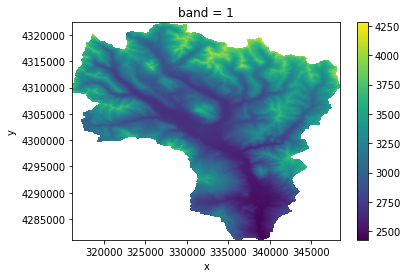

In [6]:
dem.where(dem>0).plot()

In [36]:
east_river_area_m2 = 748983000.0 # m2


# Basin Hypsometry

Text(0.5, 1.0, 'Basin Hypsometry')

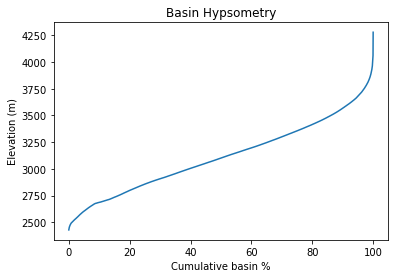

In [14]:
flat_dem = dem.values.flatten()
flat_dem_east = flat_dem[np.where(flat_dem > 0)]
flat_dem_east_sort = np.sort(flat_dem_east)
prcnt = np.linspace(0,100, len(flat_dem_east_sort))

plt.plot(prcnt, flat_dem_east_sort)
plt.ylabel("Elevation (m)")
plt.xlabel("Cumulative basin %")
plt.title("Basin Hypsometry")

# Plot Snotel Observations

In [18]:
database = "/Volumes/Transcend/EastRiverClimatePaper/Snotel/CO_snotel.db"
dbengine = "sqlite:///{}".format(database)

# select the snotel station X
df = pd.read_sql_table('380', dbengine)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# get the number of times...
ntimes = len(df.index)
days = df.index.dayofyear.values

# comptue/fix the forcing data
DailyPrecipForcing = df.IncPrecip.fillna(0) * 25.4
DailyTempForcing = ((df.TavgF-32.0)*5/9)
DailyTempForcing = DailyTempForcing.fillna(DailyTempForcing.mean())

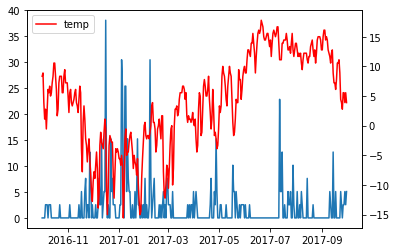

In [51]:
start, end = "2016-10-01", "2017-09-30"
fig,ax = plt.subplots()
ax1 = plt.twinx(ax)
ax.plot(DailyPrecipForcing.loc[start:end], label='precip')
ax1.plot(DailyTempForcing.loc[start:end], color='red', label='temp')
plt.legend()

# Get the USGS Streamflow info

In [52]:
## --- Gather the USGS stream observations ----#
columns = ['usgs', 'id', 'date', 'timezone', 'discharge', 'flag']
usgs_df = pd.read_csv('./data/usgs_data.txt', skiprows=41, sep='\t', names = columns)
usgs_df['date'] = pd.to_datetime(usgs_df.date)
usgs_df.set_index('date', inplace=True)

# there might be missing data -- reinterpolate to correct time (adds timesteps)
# go from hourly --> daily
usgs_df = usgs_df.resample("D").mean()
usgs_df = usgs_df.interpolate()

# convert discharge to units of discharge per unit area 
del usgs_df['id']
usgs_df['discharge_m3s'] = usgs_df['discharge']* 0.0283  # convert to m3/s
usgs_df['discharge_unit_mm'] = usgs_df['discharge_m3s'] * (24*60*60)/east_river_area_m2*1000
#       usgs_df = usgs_df.loc[start:end]



# Plot Precip and Discharge 

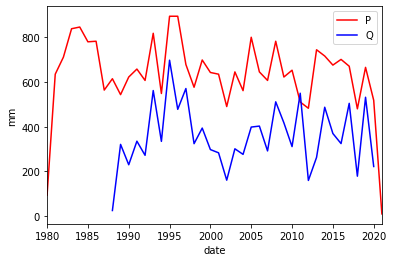

In [49]:
DailyPrecipForcing.groupby(DailyPrecipForcing.index.year).sum().plot(color='red', label='P')
usgs_df['discharge_unit_mm'].groupby(usgs_df.index.year).sum().plot(color='blue', label='Q')
plt.ylabel("mm")
plt.legend()